Vanilla Mouse Set, non random train and validation set

In [1]:
%load_ext autoreload
%autoreload 2
import math
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import numpy as np
import os
import pandas as pd
import pickle 
import re
import seaborn as sns
from collections import Counter
from model_fitting import fit_model_scDesign2
from data_simulation import simulate_count_scDesign2

np.random.seed(2)
data = pd.read_csv(os.path.dirname(os.path.abspath('')) + '/scDesign2/count_matrices/mouse_5000_random.csv', sep=',', index_col=0) #on_bad_lines='skip' the first row
data.columns = [re.sub(r"\.\d+$", '', string) for string in data.columns]
data.columns = [name.split('_', 2)[-1] for name in data.columns]
nonspikes = ~data.index.str.contains('ercc', case=False)
data_mat = data.loc[nonspikes, :]

unique_cell_type = np.unique(data.columns)
# this is for randomly selecting half of the set as training set
# train_idx = np.concatenate([np.random.choice(np.where(data.columns == x)[0],
# 		size=np.floor(len(np.where(data.columns == x)[0])/2).astype(int),
# 		replace=False) for x in unique_cell_type])
# this is for selecting the first half of the set as training set
train_idx = np.concatenate([np.where(data_mat.columns == x)[0][:math.floor(len(np.where(data_mat.columns == x)[0]) / 2)]
                            for x in unique_cell_type])
train_data = data_mat.iloc[:, train_idx]
test_data = data_mat.iloc[:, ~train_idx]

cell_type_sel = ['Stem', 'Goblet', 'Tuft', 'TA.Early', 'Enterocyte.Progenitor', 'Enterocyte.Progenitor.Early']
n_cell_new = test_data.iloc[:, test_data.columns.isin(cell_type_sel)].shape[1]
cell_type_counts = Counter(test_data.columns)
cell_type_prop = [cell_type_counts[cell_type] for cell_type in cell_type_sel]

copula_result = fit_model_scDesign2(data_mat, cell_type_sel, sim_method = 'copula', jitter=True, ncores=1)


In [2]:
sim_count_copula = simulate_count_scDesign2(copula_result, n_cell_new, sim_method='copula',
                                            cell_type_prop=cell_type_prop)
replace_dict_2 = dict(zip([str(i) for i in range(len(cell_type_sel))], cell_type_sel))
sim_count_copula = sim_count_copula.rename(columns=replace_dict_2)

In [3]:
def get_stats(mat, group, log_trans=True):
    mean = mat.mean(axis=1)
    var = mat.var(axis=1)
    cv = np.sqrt(var) / mean
    zero_gene = (mat < 1e-6).sum(axis=1) / mat.shape[1]
    zero_cell = (mat < 1e-6).sum(axis=0) / mat.shape[0]
    libsize = mat.sum(axis=0)
    if log_trans:
        mean = np.log10(mean + 1)
        var = np.log10(var + 1)
        libsize = np.log10(libsize + 1)

    summs = pd.concat([
        pd.DataFrame({'value': mean, 'measure': 'mean', 'group': group}),
        pd.DataFrame({'value': var, 'measure': 'var', 'group': group}),
        pd.DataFrame({'value': cv, 'measure': 'cv', 'group': group}),
        pd.DataFrame({'value': zero_gene, 'measure': 'drop_gene', 'group': group}),
        pd.DataFrame({'value': zero_cell, 'measure': 'drop_cell', 'group': group}),
        pd.DataFrame({'value': libsize, 'measure': 'libsize', 'group': group}),
    ])
    return summs


Vanilla Violin benchmark

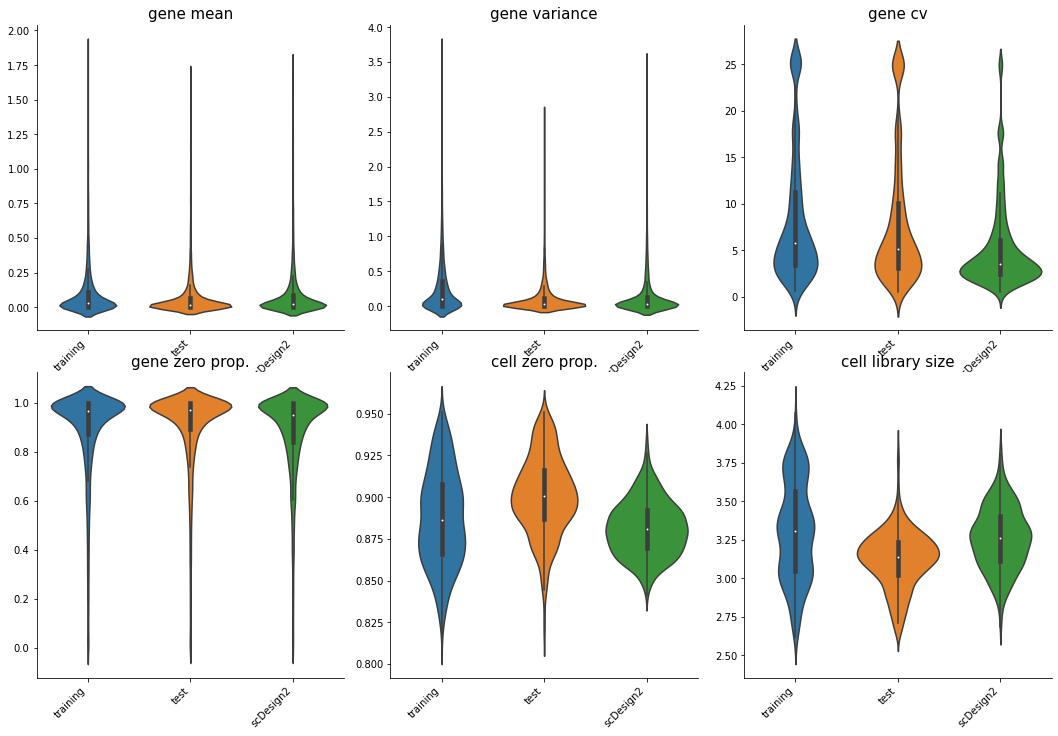

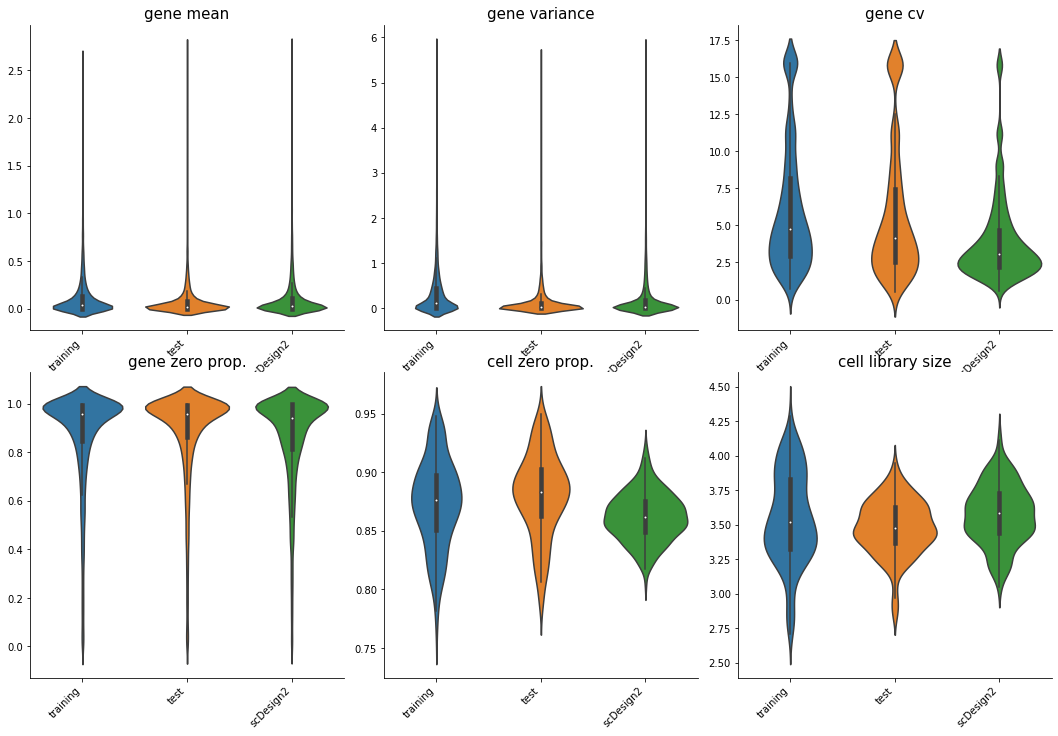

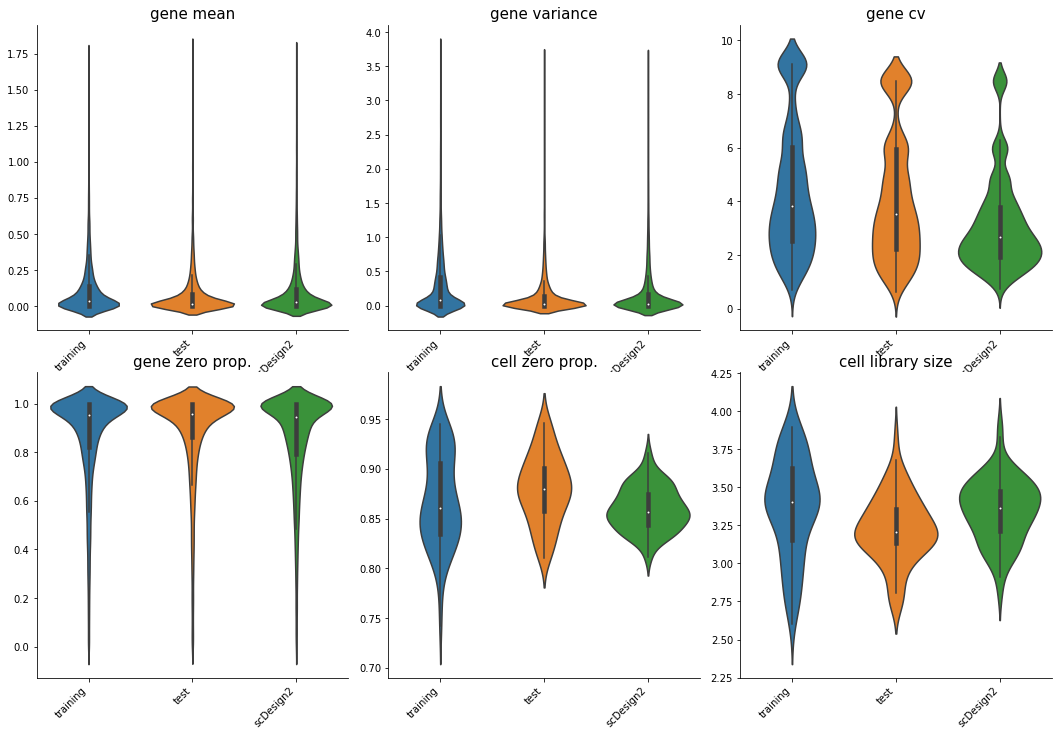

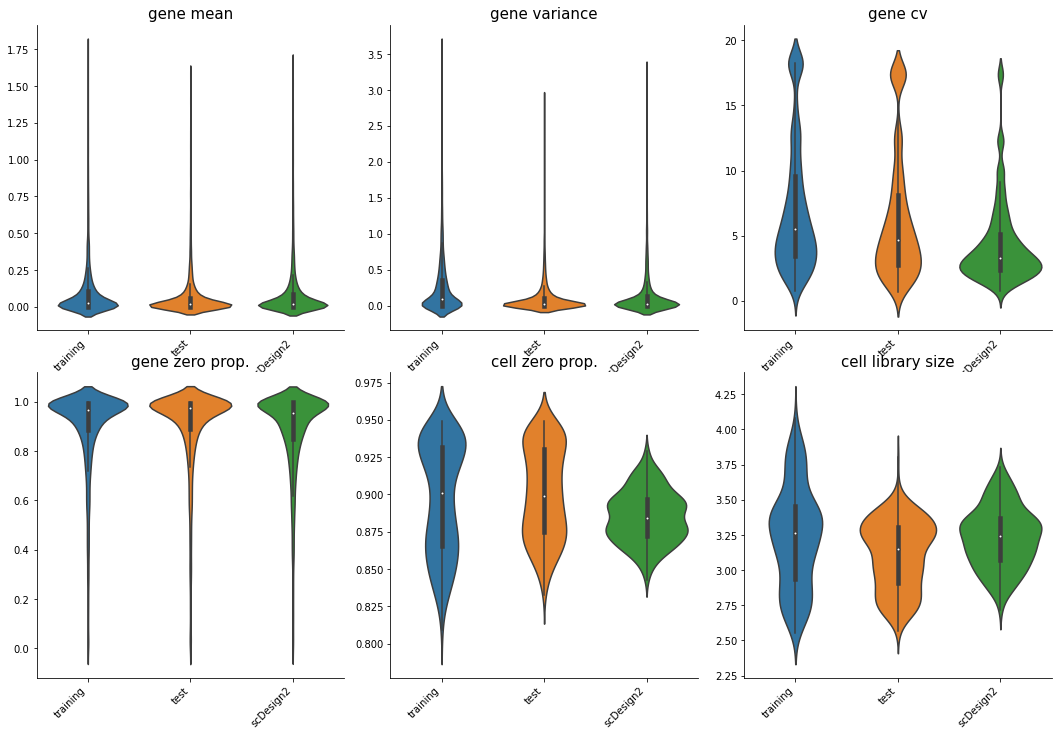

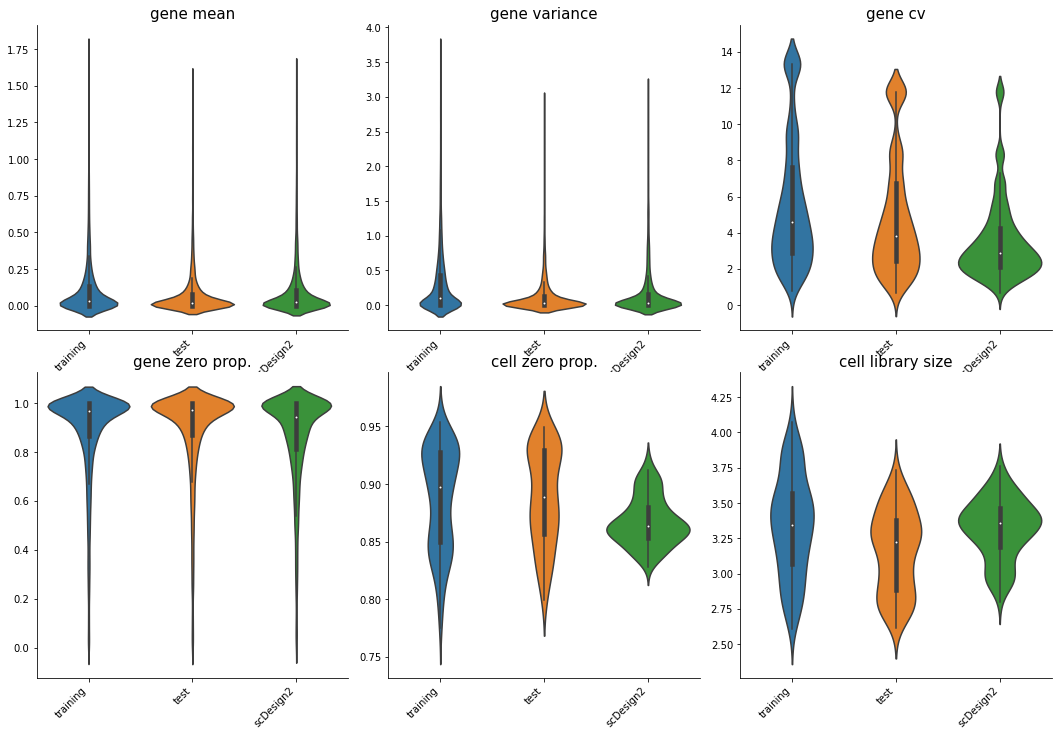

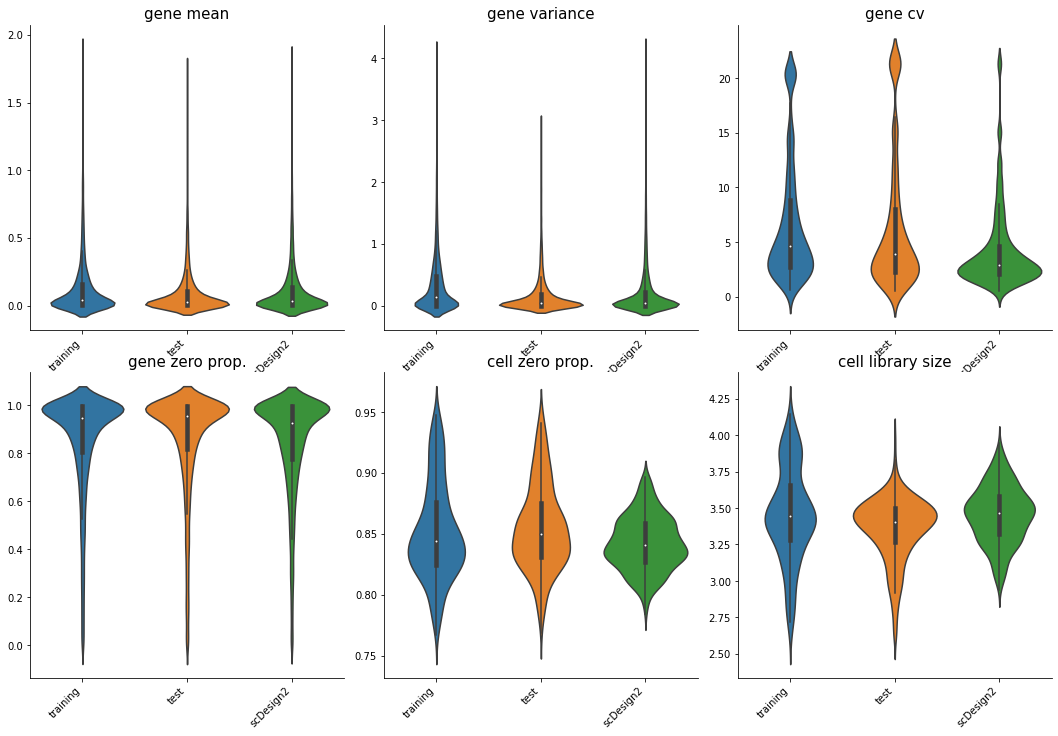

In [4]:
# Assuming traincount, testcount, and sim_count_copula are Pandas DataFrames
for cell_type in cell_type_sel:
    traincount_sel = train_data.loc[:, train_data.columns == cell_type]
    testcount_sel = test_data.loc[:, test_data.columns == cell_type]
    sim_count_copula_sel = sim_count_copula.loc[:, sim_count_copula.columns == cell_type]
    # traincount_sel = sim_count_copula.loc[:, sim_count_copula.columns == cell_type]
    # testcount_sel = sim_count_copula.loc[:, sim_count_copula.columns == cell_type]
    # sim_count_copula_sel = sim_count_copula.loc[:, sim_count_copula.columns == cell_type]

    stats_train = get_stats(traincount_sel, 'training')
    stats_test = get_stats(testcount_sel, 'test')
    stats_scDesign2 = get_stats(sim_count_copula_sel, 'scDesign2')

    stats_dat = pd.concat([stats_train, stats_test, stats_scDesign2])
    stats_dat['group'] = pd.Categorical(stats_dat['group'], categories=['training', 'test', 'scDesign2'])
    measures1 = ["mean", "var", "cv", "drop_gene", "drop_cell", "libsize"]
    measures2 = ["gene mean", "gene variance", "gene cv", "gene zero prop.", "cell zero prop.", "cell library size"]
    stats_dat['measure'] = stats_dat['measure'].replace(measures1, measures2)

    g = sns.catplot(x='group', y='value', col='measure', data=stats_dat, kind='violin', col_wrap=3, sharex=False, sharey=False)
    g.set_axis_labels("", "")
    g.set_xticklabels(rotation=45, ha='right')
    g.set_titles(col_template="{col_name}", size=15)
    plt.show()

Violin benchmark comparison R vs Python

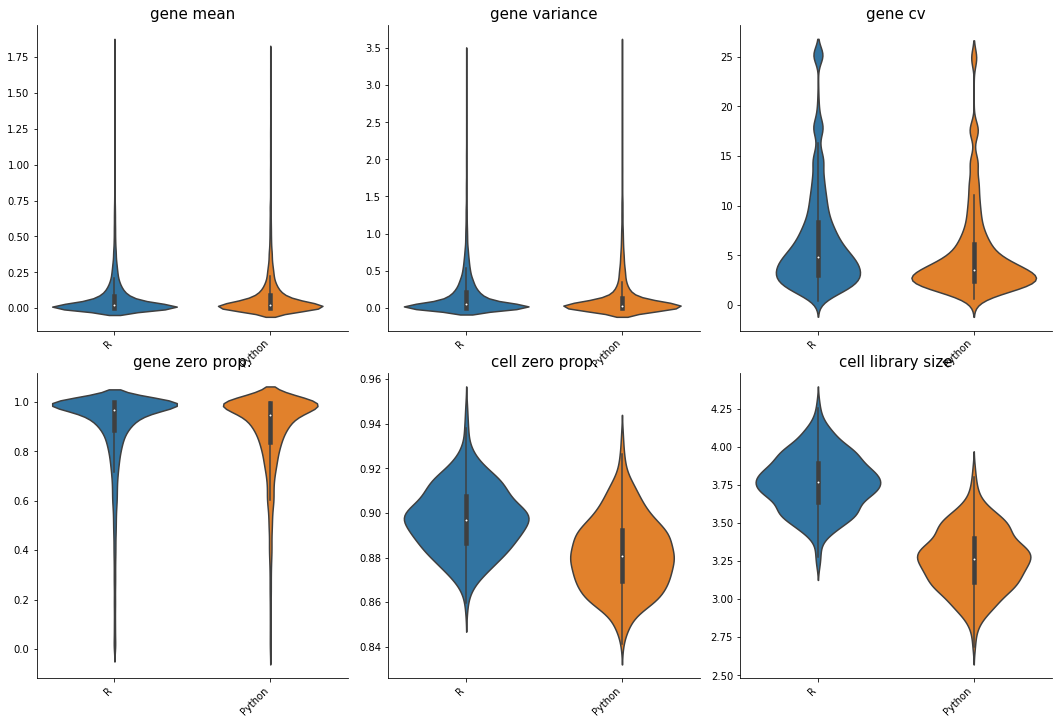

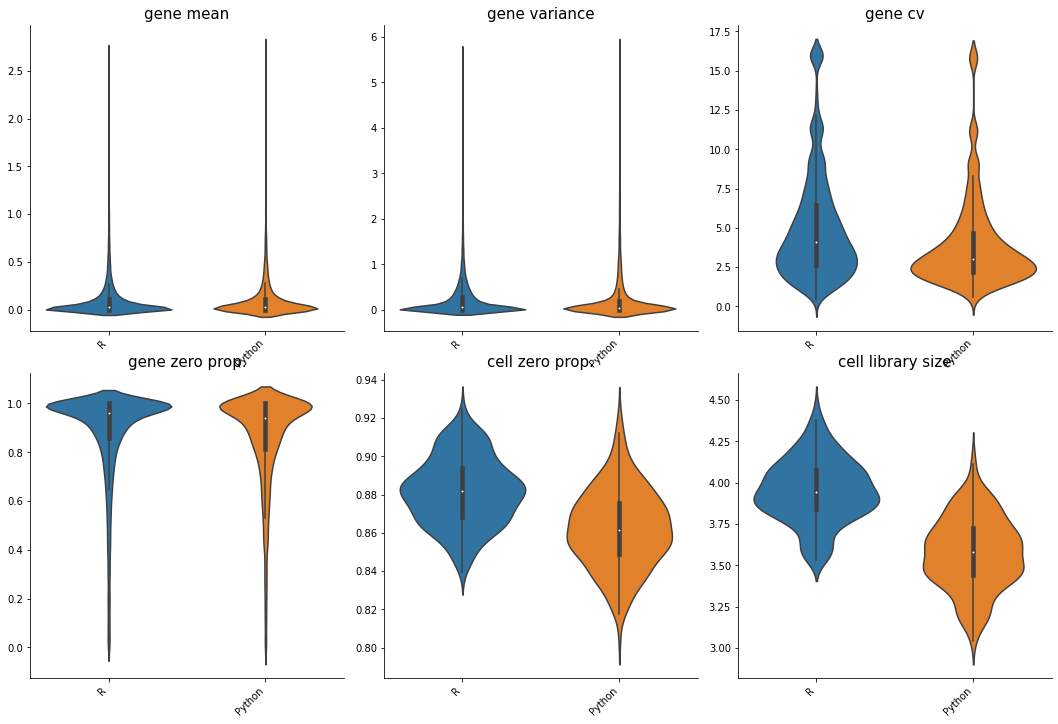

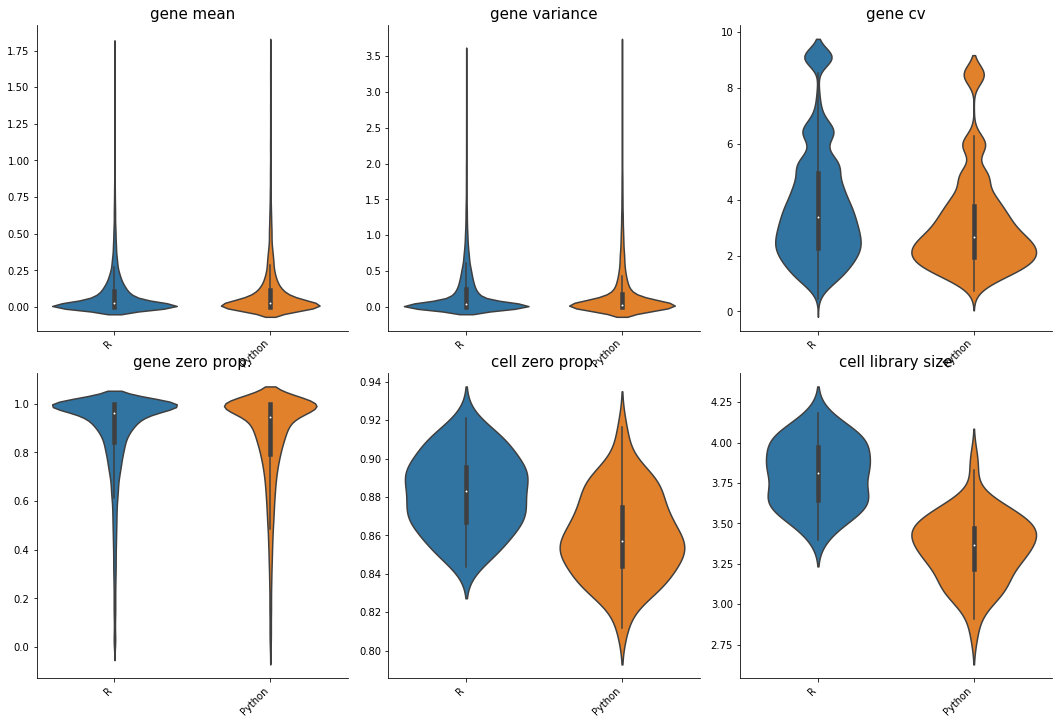

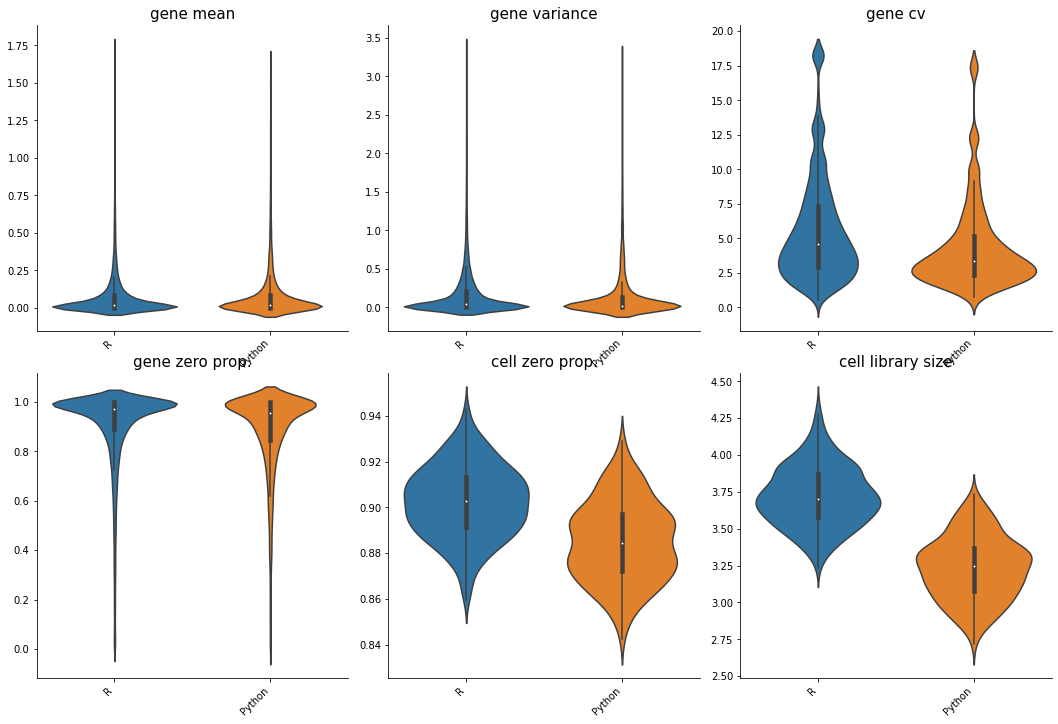

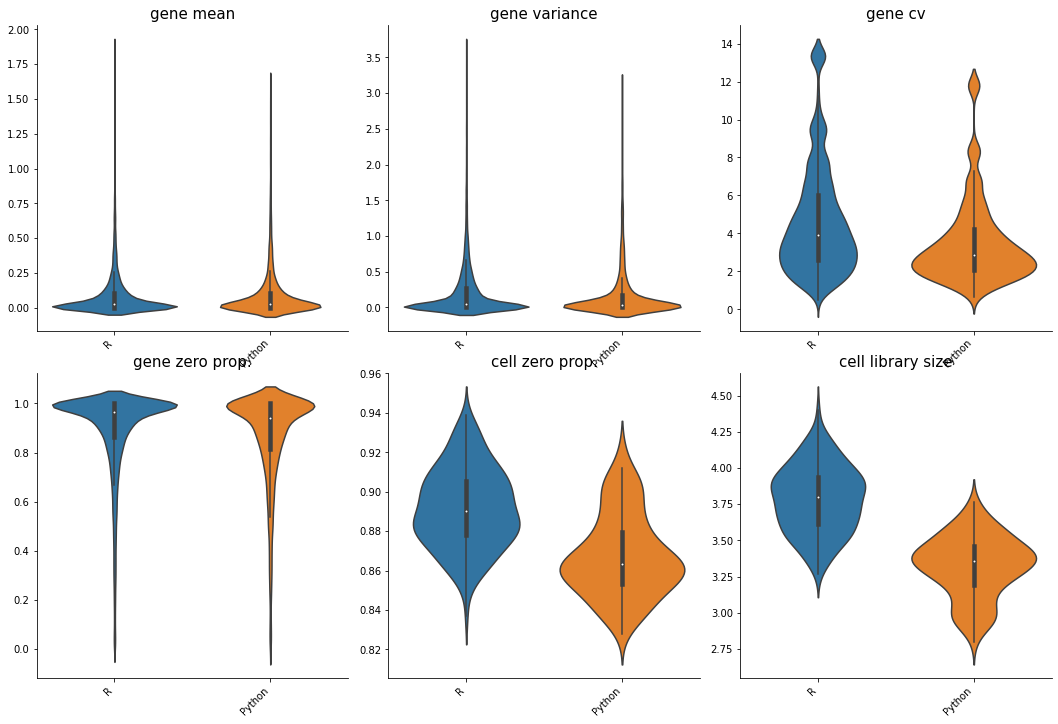

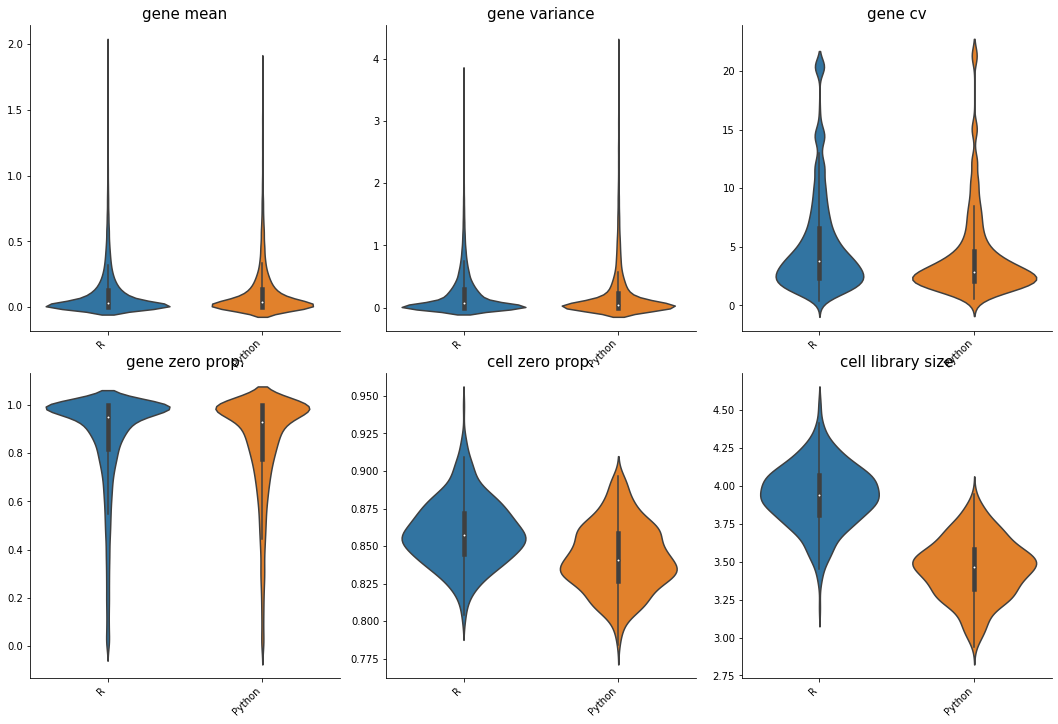

In [7]:
sc_design2_r = pd.read_csv(os.path.dirname(os.path.abspath('')) + '/scDesign2/count_matrices/R_sim_count_copula_count.csv', sep=',', index_col=0) #on_bad_lines='skip' the first row
sc_design2_r.columns = [re.sub(r"\.\d+$", "", string) for string in sc_design2_r.columns]

for cell_type in cell_type_sel:
	# traincount_sel = train_data.loc[:, train_data.columns == cell_type]
	r_sel = sc_design2_r.loc[:, sc_design2_r.columns == cell_type]
	python_sel = sim_count_copula.loc[:, sim_count_copula.columns == cell_type]
	# traincount_sel = sim_count_copula.loc[:, sim_count_copula.columns == cell_type]
	# testcount_sel = sim_count_copula.loc[:, sim_count_copula.columns == cell_type]
	# sim_count_copula_sel = sim_count_copula.loc[:, sim_count_copula.columns == cell_type]

	# stats_train = get_stats(traincount_sel, 'Training')
	stats_r = get_stats(r_sel, 'R')
	stats_python = get_stats(python_sel, 'Python')

	stats_dat = pd.concat([stats_train, stats_r, stats_python])
	stats_dat['group'] = pd.Categorical(stats_dat['group'], categories=['R', 'Python'])
	# stats_dat['group'] = pd.Categorical(stats_dat['group'], categories=['Training', 'R', 'Python'])
	measures1 = ["mean", "var", "cv", "drop_gene", "drop_cell", "libsize"]
	measures2 = ["gene mean", "gene variance", "gene cv", "gene zero prop.", "cell zero prop.", "cell library size"]
	stats_dat['measure'] = stats_dat['measure'].replace(measures1, measures2)

	g = sns.catplot(x='group', y='value', col='measure', data=stats_dat, kind='violin', col_wrap=3, sharex=False, sharey=False)
	# g = sns.catplot(x='group', y='value', col='measure', data=stats_dat, kind='violin', col_wrap=3, sharex=False, sharey=False)
	g.set_axis_labels("", "")
	g.set_xticklabels(rotation=45, ha='right')
	g.set_titles(col_template="{col_name}", size=15)
	plt.show()

Difference of the means

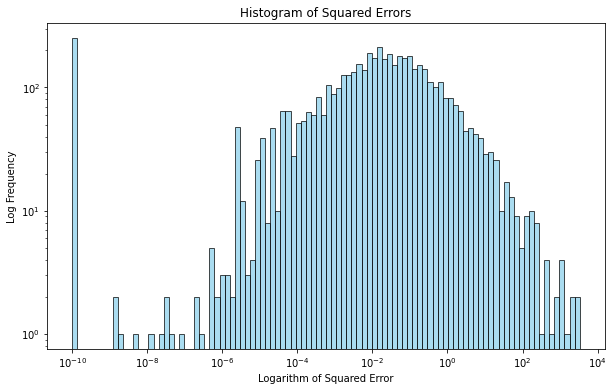

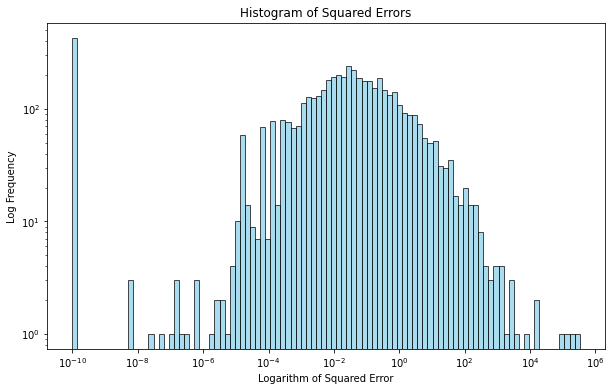

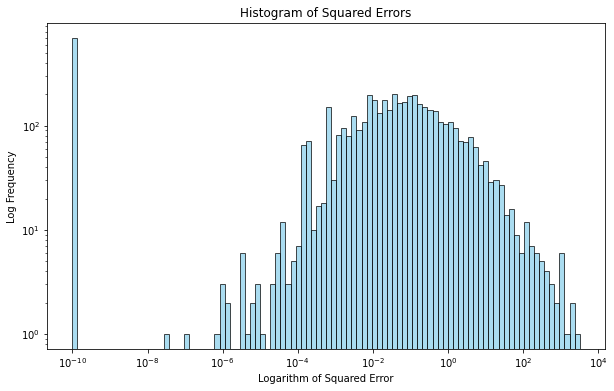

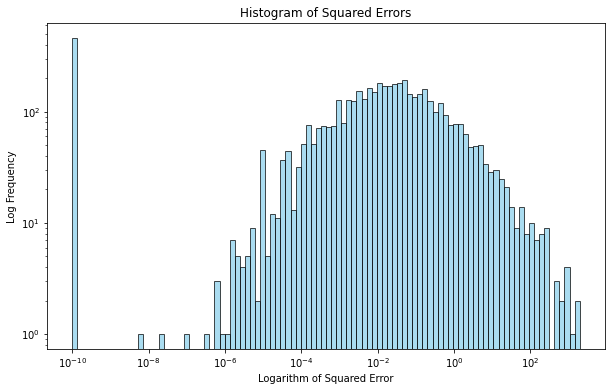

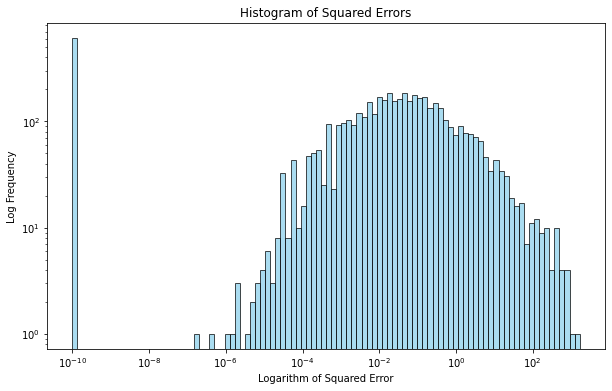

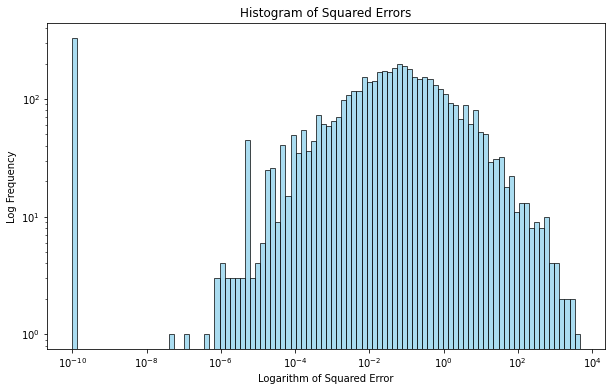

R: 0.47791798107255523
Python: 57.77741935483871
R: 0.0
Python: 574.0
R: 0.3253012048192771
Python: 56.888888888888886
R: 0.5285285285285285
Python: 44.21523178807947
R: 0.43820224719101125
Python: 40.9568345323741
R: 0.5855421686746988
Python: 68.27092511013215


In [10]:
# sc_design2_r = pd.read_csv(os.path.dirname(os.path.abspath('')) + '/scDesign2/data/R_count_matrices/R_sim_count_copula_count_all.csv', sep=',', index_col=0) #on_bad_lines='skip' the first row
sc_design2_r = pd.read_csv(os.path.dirname(os.path.abspath('')) + '/scDesign2/count_matrices/R_sim_count_copula_count.csv', sep=',', index_col=0) #on_bad_lines='skip' the first row
sc_design2_r.columns = [re.sub(r"\.\d+$", "", string) for string in sc_design2_r.columns]


for cell_type in cell_type_sel:
    r_sel = sc_design2_r.loc[:, sc_design2_r.columns == cell_type]
    python_sel = sim_count_copula.loc[:, sim_count_copula.columns == cell_type]
    x = np.mean(r_sel, axis=1)
    y = np.mean(python_sel, axis=1)
    temp = x - y
    temp = temp ** 2
    temp = temp + 1e-10
    log_errors = np.log10(temp)

    # Now, we can plot a histogram of these errors
    plt.figure(figsize=(10, 6))
    plt.hist(log_errors, bins=100, alpha=0.7, color='skyblue', edgecolor='black', log=True)
    plt.title('Histogram of Squared Errors')
    plt.xlabel('Logarithm of Squared Error')
    plt.ylabel('Log Frequency')

    def format_func(value, tick_number):
        # convert back to original value and then format
        return f'$10^{{{int(value)}}}$'

    # Create formatter
    formatter = ticker.FuncFormatter(format_func)

    # Set formatter for the x-axis
    plt.gca().xaxis.set_major_formatter(formatter)
    plt.show()

for cell_type in cell_type_sel:
    max_mse = 0
    index = 0
    sc_design2_r_cell = sc_design2_r.filter(regex='^{}$'.format(cell_type))
    sim_count_copula_cell = sim_count_copula.filter(regex='^{}$'.format(cell_type))
    for gene in range(sim_count_copula.shape[0]):
        temp = np.mean(sc_design2_r_cell.iloc[gene,:]) - np.mean(sim_count_copula_cell.iloc[gene,:])
        temp = temp * temp
        # if (temp > 1):
        #     print('R: ' + str(np.mean(sc_design2_r_cell.iloc[gene,:])))
        #     print('Python: ' + str(np.mean(sim_count_copula_cell.iloc[gene,:])))
        if temp > max_mse:
            max_mse = temp
            index = gene
    print('R: ' + str(np.mean(sc_design2_r_cell.iloc[index,:])))
    print('Python: ' + str(np.mean(sim_count_copula_cell.iloc[index,:])))

PCA & t-SNE

0             EP
1             EP
2             EP
3             EP
4             EP
          ...   
5564    EP.Early
5565    EP.Early
5566    EP.Early
5567    EP.Early
5568    EP.Early
Name: labels, Length: 5569, dtype: object
0             EP
1             EP
2             EP
3             EP
4             EP
          ...   
5564    EP.Early
5565    EP.Early
5566    EP.Early
5567    EP.Early
5568    EP.Early
Name: labels, Length: 5569, dtype: object


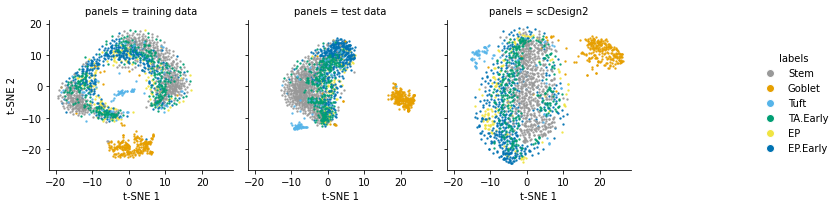

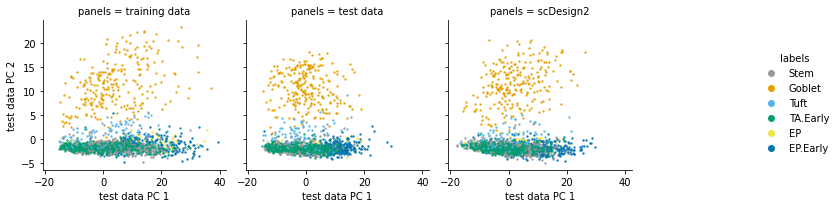

In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import seaborn as sns 
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import pickle

# Assuming traincount, testcount, cell_type_sel, and sim_count_copula are Pandas DataFrames or Series
traincount_sel = train_data.loc[:, train_data.columns.isin(cell_type_sel)]
testcount_sel = test_data.loc[:, test_data.columns.isin(cell_type_sel)]

# Perform t-SNE
df = np.log(sim_count_copula.T + 1)
tsne = TSNE(random_state=1)
Rtsne_test = tsne.fit_transform(np.log(testcount_sel.T + 1))
Rtsne_train = tsne.fit_transform(np.log(traincount_sel.T + 1))
Rtsne_copula = tsne.fit_transform(np.log(sim_count_copula.T + 1))
with open('tsne_comparison_multi_type_demo.pkl', 'wb') as f:
    pickle.dump((Rtsne_test, Rtsne_train, Rtsne_copula), f)

# Perform PCA
pca = PCA(n_components=2)
pca_test = pca.fit(np.log(testcount_sel.T + 1))
test_trans = pca_test.transform(np.log(testcount_sel.T + 1))
train_trans = (np.log(traincount_sel.T + 1) - pca_test.mean_) @ pca_test.components_.T
scDesign2_trans = (np.log(sim_count_copula.T + 1) - pca_test.mean_) @ pca_test.components_.T

with open('pca_comparison_multi_type_demo.pkl', 'wb') as f:
    pickle.dump((test_trans, train_trans, scDesign2_trans), f)


# simplify cell type names for display on plot
cell_type_sel_short = ["Stem", "Goblet", "Tuft", "TA.Early", "EP", "EP.Early"]

# a function for converting dim reduction results as input to plotting
def get_dim_red_dat(dim_red_result, traincount_sel, testcount_sel, sim_count_copula, cell_type_sel):
    dim_red_dat = pd.concat([pd.DataFrame(data) for data in dim_red_result], axis=0, ignore_index=True)
    dim_red_dat.columns = ['x', 'y']
    labels = (list(traincount_sel.columns) + list(testcount_sel.columns) +
              list(sim_count_copula.columns))
    replace_dict = dict(zip(cell_type_sel, cell_type_sel_short))
    replace_dict_2 = dict(zip([str(i) for i in range(len(cell_type_sel_short))], cell_type_sel_short))
    labels = [replace_dict.get(x, x) for x in labels]
    labels = [replace_dict_2.get(x, x) for x in labels]
    # labels = pd.Series(pd.Categorical(labels, categories=cell_type_sel))
    dim_red_dat['labels'] = labels
    print(dim_red_dat['labels'])
    panels = (['training data'] * traincount_sel.shape[1] +
              ['test data'] * testcount_sel.shape[1] +
              ['scDesign2'] * sim_count_copula.shape[1])
    dim_red_dat['panels'] = pd.Categorical(panels, categories=['training data', 'test data', 'scDesign2'])
    
    return dim_red_dat



# a function for drawing dim reduction plots
def get_dim_red_plot(dim_red_dat, xylab, plot_legend=False):
    cbPalette = {label: color for label, color in zip(cell_type_sel_short,
                    ["#999999", "#E69F00", "#56B4E9", "#009E73", "#F0E442", "#0072B2"])}

    g = sns.FacetGrid(dim_red_dat, col='panels', hue='labels', palette=cbPalette,
                      legend_out=plot_legend)
    g.map(plt.scatter, 'x', 'y', s=2, alpha=0.8)
    g.set_axis_labels(xylab[0], xylab[1])

    if plot_legend:
        handles = [Line2D([0], [0], marker='o', color='w', label=label,
                          markerfacecolor=cbPalette[label], markersize=8)
                   for label in cell_type_sel_short]
        g.add_legend(handles=handles, bbox_to_anchor=(1.05, 0.5), loc='center left')

    return g

# Example usage:
# Assuming the following data is already available in the environment:
# Rtsne_train, Rtsne_test, Rtsne_copula, traincount_sel, testcount_sel, sim_count_copula, cell_type_sel

tsne_dat = get_dim_red_dat([Rtsne_train, Rtsne_test, Rtsne_copula],
                           traincount_sel, testcount_sel, sim_count_copula, cell_type_sel)
pca_dat = get_dim_red_dat([train_trans, test_trans, scDesign2_trans],
                           traincount_sel, testcount_sel, sim_count_copula, cell_type_sel)

tsne_plot = get_dim_red_plot(tsne_dat, ['t-SNE 1', 't-SNE 2'], plot_legend=True)
plt.show()
pca_plot = get_dim_red_plot(pca_dat, ['test data PC 1', 'test data PC 2'], plot_legend=True)
# legend_plot = get_dim_red_plot(tsne_dat, ['t-SNE 1', 't-SNE 2'], plot_legend=True)
plt.show()
